Necessary imports for the whole notebook

In [5]:
#%pip install torch tensorflow
#%pip install numpy pandas
#%pip install matplotlib tqdm
#%pip install opencv-python scikit-image
#%pip install imgaug openslide-python
#%pip install scikit-learn
#%pip install nptyping
#%pip install hdf5storage
#%pip install tables
#%ls

In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import cv2

import numpy as np
import pandas as pd
from scipy.special import expit, logit

from tqdm.notebook import tqdm, trange

#from numba import jit

## Load the configurable components

First open the config file with all the necessary configurable components described.
Contains mosty data generators as other componentes still need to be rewritten.

In [7]:
import json

with open('prunning_teacher_student/prunning_ts_config.json') as ts_config_file:
    ts_config = json.load(ts_config_file)

load the basic data generators 

In [8]:
from rationai.utils.config import build_from_config, parse_configs_recursively


datagen_bool = build_from_config(parse_configs_recursively("datagen_bool", cfg_store=ts_config["named_configs"]))
generators_dict_bool = datagen_bool.build_from_template()

train_generator_bool = generators_dict_bool['train_gen']
valid_generator_bool = generators_dict_bool['valid_gen']

#datagen_ts = build_from_config(parse_configs_recursively("datagen_ts", cfg_store=ts_config["named_configs"]))
#generators_dict_ts = datagen_ts.build_from_template()

#train_generator_ts = generators_dict_ts['train_gen']
#valid_generator_ts = generators_dict_ts['valid_gen']


[12.04.2022 09:52:38][I][32168][datasources.py][load_dataset             ] Splitting DS with seed 123
[12.04.2022 09:52:46][I][32168][samplers.py][__init__                 ] RandomSampler was loaded with seed: 69420


In [9]:
batch_size = 1
train_generator_bool.set_batch_size(batch_size)
valid_generator_bool.set_batch_size(batch_size)
# train_generator_ts.set_batch_size(batch_size)
# valid_generator_ts.set_batch_size(batch_size)

[12.04.2022 09:52:54][I][32168][datasources.py][load_dataset             ] Splitting DS with seed 0
[12.04.2022 09:53:00][I][32168][generators.py][on_epoch_end             ] PyTorch generator resampled on epoch end (0s)
[12.04.2022 09:53:00][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


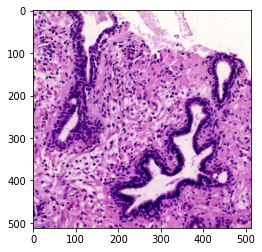

[12.04.2022 09:53:00][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


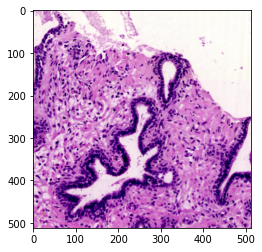

[12.04.2022 09:53:01][I][32168][generators.py][on_epoch_end             ] PyTorch generator resampled on epoch end (0s)
[12.04.2022 09:53:01][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


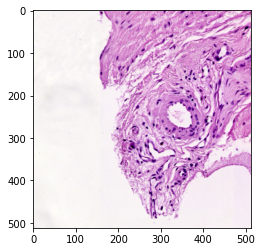

[12.04.2022 09:53:01][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


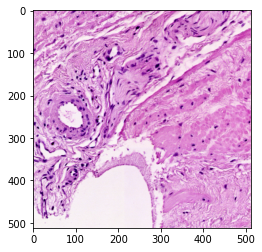

[12.04.2022 09:53:01][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


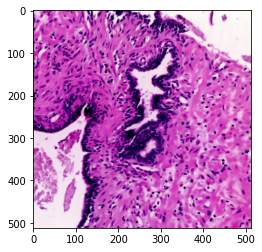

[12.04.2022 09:53:01][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


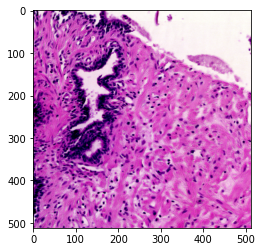

[12.04.2022 09:53:02][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


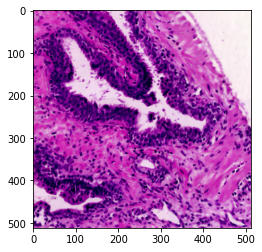

[12.04.2022 09:53:02][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


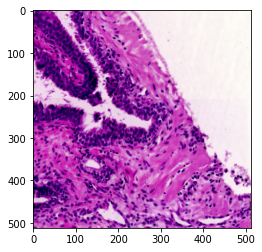

[12.04.2022 09:53:02][I][32168][generators.py][on_epoch_end             ] PyTorch generator resampled on epoch end (0s)
[12.04.2022 09:53:02][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


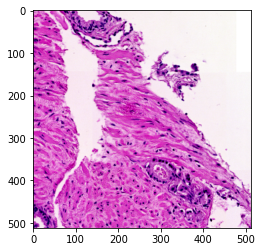

[12.04.2022 09:53:02][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


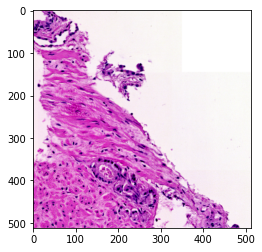

[12.04.2022 09:53:03][I][32168][generators.py][on_epoch_end             ] PyTorch generator resampled on epoch end (0s)
[12.04.2022 09:53:03][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


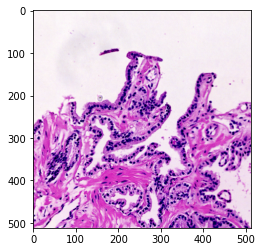

[12.04.2022 09:53:03][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


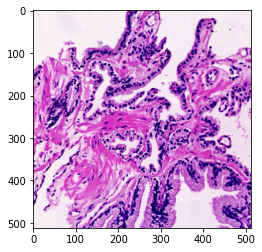

[12.04.2022 09:53:03][W][32168][image.py][set_data                 ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


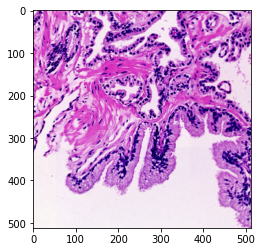

In [10]:
from rationai.utils.config import build_from_config, parse_configs_recursively

datagen_seq = build_from_config(parse_configs_recursively("datagen_seq", cfg_store=ts_config["named_configs"]))
generators_dict_seq = datagen_seq.build_from_template()
seq_generator = generators_dict_seq['just_gen_seq']
seq_generator.set_batch_size(1)

interesting_indices_intervals = [
    (688, 1528, [300, 301]),
    (1, 2344, [23, 25, 225, 226, 280, 281]), 
    (2, 874, [59, 60]), 
    (4, 1392, [2, 11, 23])
]

special_data = []


for interval, size_, indices in interesting_indices_intervals:
    for i in range(interval):
        seq_generator.sampler.next()
    
    seq_generator.on_epoch_end()
    # # plot several images
    # for i in range(25, 100):
    #     special_input_, special_output_ = seq_generator[i]
    #     special_img = special_input_.squeeze().permute([1,2,0]).numpy()
    #     plt.imshow(special_img)
    #     plt.show()
    # break
    assert len(seq_generator) == size_ 
    
    # indexes around 59 contain the critical segment
    for i in indices:
        special_input_, special_output_ = seq_generator[i]
        special_data.append((special_input_, special_output_))
        special_img = special_input_.squeeze().permute([1,2,0]).numpy()
        plt.imshow(special_img)
        plt.show()


## Modules setup

Let's import a GradCam module, defined in a separate file (for simplicity). The module should be able to be used with an arbitrary network topology that contains convolutional layers.
The idea of gradcam is that it looks into a model at the particular layer and weights the featrue map activations of the particular layer by the gradients flowing back from the following layers. Averaged together these weighted activation maps create a visual representation of what the network pays attention to.



In [11]:
from prunning_gradcam.grad_cam import GradCam

To make it easier, the GradCam module is written in such a way that it takes two modules on initialisation, which represent the two parts of the already dissected model. The model dissection has to be performed manually,
though I have provided a method for dissecting any torch.nn.Sequential model on an arbitrary layer index.


In [12]:
from prunning_gradcam.models import SequentialVGG16
from prunning_gradcam.grad_cam_tools import _load_params, dissect_sequential_model

import logging as log

# initialize the VGG model
vgg = SequentialVGG16()

# load weights from a file
_load_params(vgg, source_state_dict='transplanted-model.chkpt')

# dissect model into two parts
first_part, remaining_part = dissect_sequential_model(vgg, 30)
remaining_part_without_sigmoid, _ = dissect_sequential_model(remaining_part, -1)

grad_cam = GradCam(first_part, remaining_part)


Loading weights from a supplied state_dict...
Weights loaded: ['block1_conv1.weight', 'block1_conv1.bias', 'block1_conv2.weight', 'block1_conv2.bias', 'block2_conv1.weight', 'block2_conv1.bias', 'block2_conv2.weight', 'block2_conv2.bias', 'block3_conv1.weight', 'block3_conv1.bias', 'block3_conv2.weight', 'block3_conv2.bias', 'block3_conv3.weight', 'block3_conv3.bias', 'block4_conv1.weight', 'block4_conv1.bias', 'block4_conv2.weight', 'block4_conv2.bias', 'block4_conv3.weight', 'block4_conv3.bias', 'block5_conv1.weight', 'block5_conv1.bias', 'block5_conv2.weight', 'block5_conv2.bias', 'block5_conv3.weight', 'block5_conv3.bias', 'dense.weight', 'dense.bias']
Weights not expected: set()
Weights not present: []
Model dissected after layer "block5_relu3".
Model dissected after layer "dense".


## Math

In the original paper, authors calculate average weighted activation in a particular layer. The neuron importance factor $\alpha_k^c$ is obtained as an average gradient of the class activation $y^c$ (before the last activation function is applied) and each activation map $A^k \in \mathbb{R}^{u\times v} $ is weighted by it.

$$
\alpha_k^c = \frac{1}{Z}\sum_{i=0}^{u}\sum_{j=0}^{v} \frac{\partial \xi^c}{\partial A^k_{ij}}
$$
$$
L^c_{Grad-CAM}=ReLU(\sum_{k}\alpha^c_kA^k)
$$

$$
\frac{\partial \xi^c_i}{\partial A_{ki}} = \frac{\partial \xi^c_i}{\partial y^k_i}  \frac{\partial y^k_i}{\partial A_{ki}}
$$

$$
\frac{\partial }{\partial }
$$

Since our VGG16 uses global max pooling (GMP), the importance coefficient $\alpha_k^c$ will result in the same ranking up to a constant factor $k=uv$ for average pooling and for maxpooling, allowing us to also calculate

$$
\alpha_k^c = max_{ij}\frac{\partial y^c}{\partial A^k_{ij}}
$$

which is a little faster.



## Visualisation tools

For the purpose of visualizing the GradCAM outputs we have to have a way of plotting the heatmaps, overlaying them over the original images or somehow visualizing the activation regions.

I have coded a function that can overlay several heatmaps over a single image in one step, next to each other in a grid. 
The last column in the grid shows all the heatmaps over each other clipped.

The code is split into multiple helper functions for modularity.

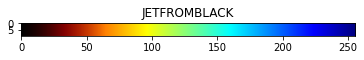

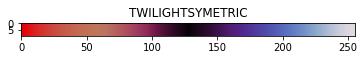

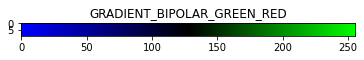

In [13]:
from typing import List, Tuple

from skimage.morphology import dilation, disk


def _COLORMAP_JETFROMBLACK():
    """Precomputes a lookup table for a custom colormap

    Returns:
        numpy.ndarray: A numpy array of shape (256,1,3) or something like that.
    """
    lut = np.asarray([[np.ones(3)*i for _ in range(1)] for i in range(256)], dtype=np.uint8)
    lut = cv2.applyColorMap(lut, cv2.COLORMAP_JET)
    #lut = cv2.cvtColor(lut, cv2.COLOR_BGR2RGB)
    beginning = lut[:64, 0].astype(np.float64)
    beginning *= np.stack([np.arange(64) * (1/64) for _ in range(3)], axis=1)
    lut[:64, 0] = beginning.astype(np.uint8)
    plt.imshow(np.swapaxes(np.repeat(lut, 10, axis=1), 0, 1))
    plt.title("JETFROMBLACK")
    plt.show()
    return lut

def _COLORMAP_TWILIGHTSYMETRIC():
    """Precomputes a lookup table for a custom colormap

    Returns:
        numpy.ndarray: A numpy array of shape (256,1,3) or something like that.
    """
    lut = np.asarray([[np.ones(3)*i for _ in range(1)] for i in range(256)], dtype=np.uint8)
    lut = cv2.applyColorMap(lut, cv2.COLORMAP_TWILIGHT)
    #lut = cv2.cvtColor(lut, cv2.COLOR_BGR2RGB)
    beginning = lut[:64, 0].astype(np.float64)
    beginning *= np.stack([np.ones(64), np.arange(64) * (1/64), np.arange(64) * (1/64)], axis=1)
    lut[:64, 0] = beginning.astype(np.uint8)

    middle = lut[96:160, 0].astype(np.float64)
    middle *= np.stack([np.sqrt(np.absolute(np.linspace(-1, 1, 64))) for _ in range(3)], axis=1)
    lut[96:160, 0] = middle.astype(np.uint8)

    #print(lut[127:130])
    plt.imshow(np.swapaxes(np.repeat(lut, 10, axis=1), 0, 1))
    plt.title("TWILIGHTSYMETRIC")
    plt.show()
    return lut

# return a colormap containing gradient from green to red with zeros in the middle
def _COLORMAP_GRADIENT_BIPOLAR_GREEN_YELLOW():
    lut_red = np.asarray([[np.asarray([0, 0, i]) for _ in range(1)] for i in range(0, 256, 2)], dtype=np.uint8)
    lut_yellow = np.asarray([[np.asarray([0, i, 0]) for _ in range(1)] for i in range(0, 256, 2)], dtype=np.uint8)
    lut = np.concatenate((lut_red[::-1], lut_yellow), axis=0)
    plt.imshow(np.swapaxes(np.repeat(lut, 10, axis=1), 0, 1))
    plt.title("GRADIENT_BIPOLAR_GREEN_RED")
    plt.show()
    return lut



# precomputed stuff like color LUTs and so on
_COLORMAP_JETFROMBLACK = _COLORMAP_JETFROMBLACK()
_COLORMAP_TWILIGHTSYMETRIC = _COLORMAP_TWILIGHTSYMETRIC()
_COLORMAP_GRADIENT_BIPOLAR_GREEN_RED = _COLORMAP_GRADIENT_BIPOLAR_GREEN_YELLOW()


def shiftscale(img: np.ndarray, shift:float=None, scale:float=None):
    """Function to scale and shift real values in a tensor.
    By default shiftscales by min and max to obtain values in the range [0..1]
    Creates a copy of the scaled tensor and returns it.

    Args:
        img (np.ndarray): Scaled tensor
        shift (float, optional): This value is added to each element of the tensor prior to scaling. Defaults to None.
        scale (float, optional): All values are multiplied by this value after shifting. Defaults to None.

    Returns:
        _type_: New tensor with shifted and scaled values.
    """
    if shift is None:
        shift = -img.min()
    if scale is None:
        scale = 1/img_max

    # create a new picture tensor copy by not using inplace addition
    img = img + shift  
    img_max = img.max()
    if img_max != 0:
        img *= scale
    return img


def resize_and_color(bitmap: np.ndarray, dims:Tuple[int], colormap_lut: np.ndarray=_COLORMAP_JETFROMBLACK) -> np.ndarray:
    overlay = cv2.resize(bitmap, dims, interpolation=cv2.INTER_NEAREST)
    overlay = np.uint8(255 * overlay)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
    overlay = cv2.LUT(overlay, colormap_lut)
    return overlay


def superimpose(image: np.ndarray, overlay: np.ndarray, strategy:str='ceil'):
    if strategy=='additive_overflow_compress':  
        # tries to add the overlay without any modifications. Just slaps it on top of the image.
        # But then, when pixels overflows, it compresses them back to range [0..1]
        # First add the overlay to the image with a scaling factor
        res = image + overlay*0.75
        
        # get the maximum values across channels and stack them to get 3 channels again
        channel_maximums = np.stack([np.max(res, axis=2) for _ in range(3)], axis=2)
        
        # get the locations of overflowing pixels using the maximum channel value
        overflow_locations = channel_maximums > 255
        #print('OVERFLOWS', overflow_locations.shape)
        # downscale the overflowing pixels so that the maximum value is 255
        res[overflow_locations] = res[overflow_locations] * (255 / channel_maximums[overflow_locations])

    elif strategy=='sub':
        res = np.maximum(image - overlay*0.5, 0)
    elif strategy=='linear_combination':
        res = image*0.5 + overlay*0.5
    elif strategy=='outline':
        footprint = disk(3)
        bool_map = overlay.sum(axis=2) > 0
        dilated = dilation(bool_map, footprint)
        outline = dilated & ~bool_map
        res = image.copy()
        # fill the outline with specific color
        res[outline] = [0, 0, 0]
    elif strategy=='black_alpha_blend':
        # use custom alpha blending to combine the two images
        alpha = np.divide(np.max(overlay, axis=2, keepdims=True), 255.)
        #print(alpha.shape, image.shape, overlay.shape)
        # just add the overlay to the image
        res = image + overlay
        res = image*(1-alpha) + overlay#*alpha

    else:
        raise NotImplementedError(f'There is no strategy with name {strategy}!')

    return res.astype(np.uint8)




def plot_bitmap_overlays(bitmaps: List[np.ndarray], base_image: np.ndarray, save_file:str=None, colormap_lut: np.ndarray=_COLORMAP_GRADIENT_BIPOLAR_GREEN_RED, strategy='black_as_alpha', heatmaps_titles=None):
    """
    Creates a grid plot from a list of overlays and a base image.
    Expects the overlay arrays in the list to be of shape [W1, H1] and the image of shape [3, W2, H2],
    where W1, H1, W2, H2 are widths and heights, not required to be of same size. Overlays are stretched to the image size.
    
    There are several rows plotted, leftmost column contain teh base images, rightmost column contains all overlays.
    Images in in columns in between represent each overlay separately

    Args:
        bitmaps (List[np.ndarray]): The bitmaps that are going to be transformed into overlays
        base_image (np.ndarray): The underlying image
        save_file (str, optional): If there is a string present, the figure is saved into a file. Defaults to None.
    """
    
    fig, ax = plt.subplots(nrows=2, ncols=len(bitmaps)+1, sharex=True, sharey=True, figsize=(10*(len(bitmaps)+1), 10*2))
   
    # mark the row indices for flexibility
    overlay_row = 0
    superimposed_row = 1

    # in the first column, just print the original image and the colorscale
    ax[overlay_row,0].imshow(base_image)
    ax[overlay_row,0].title.set_text('Base image')
    #base_image = scaleshift_to_unit_range(base_image)
    colorscale = np.swapaxes(np.repeat(colormap_lut, 10, axis=1), 0, 1)
    #ax[superimposed_row][0].imshow(cv2.resize(colorscale, base_image.shape[:2]))
    #ax[superimposed_row][0].title.set_text('Heatmap overlay colorscale')

    # extract the ahred tick Grouper objcts from the axes and remove the first column axes
    axLB = ax[superimposed_row,0]
    axLB.get_shared_x_axes().remove(axLB)
    axLB.get_shared_y_axes().remove(axLB)
    #axLB.clear()

    # Create and assign new ticker
    xticker = matplotlib.axis.Ticker()
    yticker = matplotlib.axis.Ticker()
    axLB.xaxis.major = xticker
    axLB.yaxis.major = yticker

    # The new ticker needs new locator and formatters
    xloc = matplotlib.ticker.AutoLocator()
    xfmt = matplotlib.ticker.StrMethodFormatter('{x:,.2f}')

    yloc = matplotlib.ticker.AutoLocator()
    yfmt = matplotlib.ticker.ScalarFormatter()

    # Assign the locators and formatters to the axes
    axLB.xaxis.set_major_locator(xloc)
    axLB.xaxis.set_major_formatter(xfmt)
    axLB.yaxis.set_major_locator(yloc)
    axLB.yaxis.set_major_formatter(yfmt)

    axLB.imshow(cv2.resize(colorscale, (base_image.shape[0], 32)))
    axLB.title.set_text('Heatmap overlay colorscale')

    # set the new x-axis tick labels to the logit values of the colormap with 3 valid digits
    
    
    axLB.set_xticks(np.linspace(0, 511, 11, endpoint=True, dtype=np.int32))
    axLB.set_xticklabels(['-∞', *logit(np.linspace(1/11, 10/11, 9, endpoint=True)).round(2), '+∞'])
    # axLB.set_xticklabels(expit(np.linspace(-1, 1, 10, endpoint=False)))

    #set yticks empty
    axLB.set_yticks([])

    
    base_image_255 = (base_image*255)
    
    # for each bitmaps get the overlays and plot them
    for column, bitmap in enumerate(iterable=bitmaps, start=1):
        overlay = resize_and_color(bitmap, base_image.shape[:2], colormap_lut=colormap_lut)
        ax[overlay_row][column].imshow(overlay)  # show the separate overlay on the first row
        if heatmaps_titles is not None:
            ax[overlay_row][column].title.set_text(heatmaps_titles[column-1])

        # impose the overlay on top of the base image
        ax[superimposed_row][column].imshow(superimpose(base_image_255, overlay, strategy))  # show the superimposed image on the second row
        
    if save_file is not None:
        fig.savefig(save_file, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()
    

def plot_bitmap_matrix(bitmaps: List[np.ndarray], base_image:np.ndarray, columns:int=8, save_file:str=None, colormap_lut: np.ndarray=_COLORMAP_GRADIENT_BIPOLAR_GREEN_RED, heatmaps_titles=None, size_factor=10):
    """
    Creates a grid plot from a list of overlays and a base image.
    Expects the overlay arrays in the list to be of shape [W1, H1] and the image of shape [3, W2, H2],
    where W1, H1, W2, H2 are widths and heights, not required to be of same size. Overlays are stretched to the image size.
    
    The bitmaps are plotted in multiple rows by a specified number next to each other, each getting an optional title.
    If a save_file parameter is provided the plts are saved into a file instead of showing.
    
    Args:
        bitmaps (List[np.ndarray]): The bitmaps that are going to be transformed into overlays
        base_image (np.ndarray): The underlying image
        columns (int, optional): The number of columns in the grid. Defaults to 20.
        save_file (str, optional): If there is a string present, the figure is saved into a file. Defaults to None.
    """
    rows = len(bitmaps)//columns + 1
    fig, ax = plt.subplots(nrows=rows, ncols=columns, sharex=True, sharey=True, figsize=(size_factor*columns, size_factor*rows))
    
    # plot the base image and colormap lut into the first row
    ax[0,0].imshow(base_image)
    ax[0,0].title.set_text('Base image')

    colorscale = np.swapaxes(np.repeat(colormap_lut, 10, axis=1), 0, 1)

    # extract the ahred tick Grouper objcts from the axes and remove the first column axes
    axLB = ax[0,1]
    axLB.get_shared_x_axes().remove(axLB)
    axLB.get_shared_y_axes().remove(axLB)
    #axLB.clear()

    # Create and assign new ticker
    xticker = matplotlib.axis.Ticker()
    yticker = matplotlib.axis.Ticker()
    axLB.xaxis.major = xticker
    axLB.yaxis.major = yticker

    # The new ticker needs new locator and formatters
    xloc = matplotlib.ticker.AutoLocator()
    xfmt = matplotlib.ticker.StrMethodFormatter('{x:,.2f}')

    yloc = matplotlib.ticker.AutoLocator()
    yfmt = matplotlib.ticker.ScalarFormatter()

    # Assign the locators and formatters to the axes
    axLB.xaxis.set_major_locator(xloc)
    axLB.xaxis.set_major_formatter(xfmt)
    axLB.yaxis.set_major_locator(yloc)
    axLB.yaxis.set_major_formatter(yfmt)

    axLB.imshow(cv2.resize(colorscale, (base_image.shape[0], 32)))
    axLB.title.set_text('Heatmap overlay colorscale')

    # set the new x-axis tick labels to the logit values of the colormap with 3 valid digits
    
    
    axLB.set_xticks(np.linspace(0, 511, 11, endpoint=True, dtype=np.int32))
    axLB.set_xticklabels(['-∞', *logit(np.linspace(1/11, 10/11, 9, endpoint=True)).round(2), '+∞'])
    # axLB.set_xticklabels(expit(np.linspace(-1, 1, 10, endpoint=False)))

    #set yticks empty
    axLB.set_yticks([])

    # fill the remaining axes in the first row so that the grid is not stretched
    #for column in range(2, columns):


       

    # plot the heatmaps into the grid and start from the second row
    # use non-persistent tqdm with a title to show the progress
    for i, bitmap in tqdm(enumerate(iterable=bitmaps, start=columns), total=len(bitmaps), desc='Plotting heatmaps', unit='overlay', leave=False):
        overlay = resize_and_color(bitmap, base_image.shape[:2], colormap_lut=colormap_lut)
        ax[i//columns][i%columns].imshow(overlay)
        if heatmaps_titles is not None:
            ax[i//columns][i%columns].title.set_text(heatmaps_titles[i-columns])
    
    # fill in the remaining axes in the first row with empty images so that the grid is complete and not stretched
    # for column in range(i+1, columns):
    #     ax[i//columns][i%columns].imshow(np.ones(base_image.shape[:2]))

    
        
    if save_file is not None:
        fig.savefig(save_file, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()
    
    

    
    



In [14]:
from typing import Union


# average value counter
class AVG:
    """This counter should work for scalars and for torch.Tensors (maybe even for numpy.ndarrays)
    """
    sum_: Union[float, torch.Tensor]
    count: Union[float, torch.Tensor]
    value: Union[float, torch.Tensor]
    def __init__(self, sum_=None, count=None):
        self.sum_ = sum_
        self.count = count
        self.value = None
    
    def record(self, value, weight=1):
        if self.sum_ is None:
            self.sum_ = value
            self.count = weight
        else:
            self.sum_ += value
            self.count += weight
        self.value = None

    def __call__(self):
        if self.value is None:
            self.value = self.sum_ / self.count
        return self.value
        
device_ = 0
# set the evaluation mode
grad_cam.eval()
grad_cam.cuda(device_)

epochs_ = 1
max_examples = 20

images_list = []
activations_list = []
gradients_list = []
predictions_list = []


generator = special_data
for epoch_ in range(epochs_):
    print('Generator has', len(generator), 'examples in this epoch.')
    for batch_idx in tqdm(range(min(len(generator), max_examples))):

        input_, target = generator[batch_idx]
        input_ = input_.type(torch.float)

        # transform to a 3 channel image shape expected by pyplot
        img = (input_.squeeze().permute([1,2,0]).numpy() + 1.) / 2.
        images_list.append(img)
        
        input_ = input_.cuda(device_)
        pred = grad_cam(input_)

        # check the model decision
        is_cancer = pred > 0.5
        is_cancer = is_cancer.cpu()
        
        if is_cancer == target: 
            _t = 'T'
        else:
            _t = 'F'
        
        _t += 'P' if is_cancer else 'N'
        predictions_list.append(_t)
        
        # get the gradient of the output with respect to the parameters of the model
        pred.backward()


        with torch.no_grad():
            # pull the gradients out of the model
            gradients = grad_cam.get_activations_gradient().cpu().squeeze(0)
            gradients_list.append(gradients)

            # get the activations of the last convolutional layer
            activations = grad_cam.get_activations().cpu().squeeze(0)
            activations_list.append(activations)

            # # pool the gradients across the feature maps and batch
            # pooled_gradients = torch.mean(gradients, dim=[2, 3])
            # #pooled_gradients = torch.amax(gradients, dim=(0, 2, 3))
            
            
            # # get the sorted indices of the gradients flowing back
            # sorted_gradient_indices = torch.argsort(pooled_gradients, dim=-1, descending=True).numpy()
            
            # # weight the channels by corresponding gradients through broadcasting multiplication
            # weighted_activations = (activations * pooled_gradients.unsqueeze(1).unsqueeze(2)).numpy()
            # activations = activations.numpy()

            # # select some interesting weighted activations
            # selection = [*sorted_gradient_indices[:10], *sorted_gradient_indices[-10:]]
            # heatmaps = activations[selection, :, :]

            # # relu on top of the heatmap, expression (2) in https://arxiv.org/pdf/1610.02391.pdf
            # #heatmaps = np.maximum(heatmaps, 0)
            
            # # row_mins = heatmaps.min(axis=(1, 2), keepdims=True)

            # # # normalize all at once
            # # row_maxs = heatmaps.max(axis=(1, 2), keepdims=True)
            
            # # nonzero_idx = (row_maxs != 0).squeeze()
            # # heatmaps[nonzero_idx] /= row_maxs[nonzero_idx]  # can't avoid division here

            # # heatmaps_titles = [f'Scaled by {1/row_maxs[i].item():.2f}, rank {pooled_gradients[selection[i]]:.4E}' if row_maxs[i] > 0 else f'No positive act., rank {pooled_gradients[selection[i]]:.4E}' for i in range(len(selection))]
            
            # print(heatmaps.shape)

            # heatmaps_titles = [f'Transformed with logit, rank {pooled_gradients[selection[i]]:.4E}' for i in range(len(selection))]
            # heatmaps = expit(heatmaps)
            
            # # heatmaps = np.append(heatmaps, np.max(np.sum(weighted_activations[selection]), 0) * (1/weighted_activations[selection].max()))
            # # heatmaps_titles.append('Original GradCAM')

            
            
            # with plt.ioff():
            #     plot_bitmap_overlays(heatmaps, img, 
            #         save_file=f'grad_cam_fmwise_special_blaa_{batch_idx}.jpg',
            #         colormap_lut=_COLORMAP_GRADIENT_BIPOLAR_GREEN_RED,
            #         strategy='black_as_alpha',
            #         heatmaps_titles=heatmaps_titles)
            #     #plot_bitmap_overlays(heatmaps, img, f'grad_cam_fmwise_special_outl_{batch_idx}.jpg', strategy='outline', heatmaps_titles=heatmaps_titles)
                
                
            #     #plot_bitmap_overlays(heatmaps, img, f'grad_cam_fmwise_ceil_{batch_idx}.jpg', strategy='ceil', heatmaps_titles=heatmaps_titles)
            #     # plot_bitmap_overlays(heatmaps, img, f'grad_cam_fmwise_subt_{batch_idx}.png', strategy='sub')
                

Generator has 13 examples in this epoch.


  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
from sklearn.cluster import KMeans


with torch.no_grad():
    for i in trange(len(activations_list)):
        img = images_list[i]
        activations = activations_list[i]
        gradients = gradients_list[i]
        pred_checked = predictions_list[i]

        #print(activations.shape, gradients.shape, pred_checked)
        
        # pool the gradients across the feature maps and batch
        pooled_gradients = torch.mean(gradients, dim=[1, 2])
        #pooled_gradients = torch.amax(gradients, dim=(0, 2, 3))
        
        
        # get the sorted indices of the gradients flowing back
        sorted_gradient_indices = torch.argsort(pooled_gradients, dim=-1, descending=True).numpy()
        
        
        # weight the channels by corresponding gradients through broadcasting multiplication
        weighted_activations = (activations * pooled_gradients.unsqueeze(1).unsqueeze(2)).numpy()
        activations = activations.numpy()

        # select some interesting weighted activations
        selection = [*sorted_gradient_indices[:10], *sorted_gradient_indices[-10:]]
        heatmaps = activations[selection, :, :]
        # get negative values for the second half of the heatmaps
        heatmaps[-10:] = -heatmaps[-10:]

        # relu on top of the heatmap, expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        #heatmaps = np.maximum(heatmaps, 0)
        
        # row_mins = heatmaps.min(axis=(1, 2), keepdims=True)

        # # normalize all at once
        # row_maxs = heatmaps.max(axis=(1, 2), keepdims=True)
        
        # nonzero_idx = (row_maxs != 0).squeeze()
        # heatmaps[nonzero_idx] /= row_maxs[nonzero_idx]  # can't avoid division here

        # heatmaps_titles = [f'Scaled by {1/row_maxs[i].item():.2f}, rank {pooled_gradients[selection[i]]:.4E}' if row_maxs[i] > 0 else f'No positive act., rank {pooled_gradients[selection[i]]:.4E}' for i in range(len(selection))]
        
        # generate titles for the heatmaps using gradient values and some text
        heatmaps_titles = [f'Transformed with logit, rank {pooled_gradients[selection[i]]:.4E}' for i in range(len(selection))]
        heatmaps = expit(heatmaps)
        
        # append original gradcam heatmap (weighted sum of activations)
        relued_gradcam = np.maximum(np.sum(weighted_activations[selection], axis=0, keepdims=True), 0.)
        max_ = relued_gradcam.max()
        # normalize to [0.5, 1]. The colormap is for [0, 1], which encodes values from -inf to inf, here we have only positive values
        normalized_gradcam = (relued_gradcam * 1/(2*max_)) + 1/2  
        heatmaps = np.append(heatmaps, normalized_gradcam, axis=0)
        heatmaps_titles.append('Original GradCAM')

        
        with plt.ioff():
            plot_bitmap_overlays(heatmaps, img, 
                save_file=f'images/gcam_{i}_{pred_checked}.jpg',
                colormap_lut=_COLORMAP_GRADIENT_BIPOLAR_GREEN_RED,
                strategy='additive_overflow_compress',
                heatmaps_titles=heatmaps_titles)
            #plot_bitmap_overlays(heatmaps, img, f'grad_cam_fmwise_special_outl_{batch_idx}.jpg', strategy='outline', heatmaps_titles=heatmaps_titles)
            
            
            #plot_bitmap_overlays(heatmaps, img, f'grad_cam_fmwise_ceil_{batch_idx}.jpg', strategy='ceil', heatmaps_titles=heatmaps_titles)
            # plot_bitmap_overlays(heatmaps, img, f'grad_cam_fmwise_subt_{batch_idx}.png', strategy='sub')
            




  0%|          | 0/13 [00:00<?, ?it/s]

### Clustering

Let's try to cluster the activations so that we can categorise structures the network is looking for.


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def find_optimal_cluster_count(activations, n_clusters_range, n_init=10, metric='inertia', plot:bool=True, fig: plt.Figure=None, title=None):
    """
    This method tries to generate clusters using KMeans for multiple numbers of centroids
    and returns the selected metric for the respective cluster counts.

    If plot is True, the metric values are plotted.

    :param activations: The activations to cluster.
    :param n_clusters_range: The range of cluster counts to try.
    :param n_init: The number of times KMeans is run with different centroid seeds.
    :param metric: The metric to use for the clustering.
    :param plot: Whether to plot the metric values.
    """
    if metric == 'inertia':
        metric_values = []
        for n_clusters in n_clusters_range:
            kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=42).fit(activations)
            metric_values.append(kmeans.inertia_)
    elif metric == 'silhouette':
        metric_values = []
        for n_clusters in n_clusters_range:
            kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=42).fit(activations)
            # get pairwise distances between samples and centroids
            distances = kmeans.transform(activations)
            # calculate the silhouette score for each pair
            metric_values.append(silhouette_score(distances, kmeans.labels_, metric='euclidean'))

            
    if plot:
        if title is None:
            title = f'{metric} for different cluster counts'
        plt.plot(n_clusters_range, metric_values)
        plt.xlabel('Number of clusters')
        plt.ylabel(f'{metric} score')
        plt.title(title)
        plt.show()
    return metric_values

  0%|          | 0/13 [00:00<?, ?it/s]

tensor(262) tensor(250)
tensor(0.0034) tensor(-0.0027)


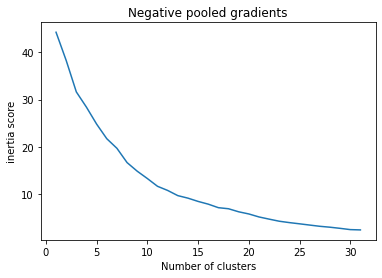

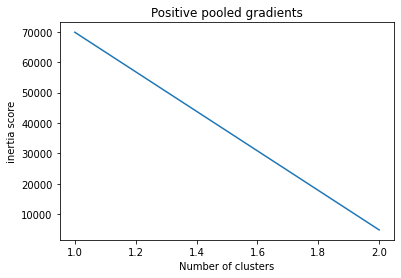

tensor(262) tensor(250)
tensor(0.0028) tensor(-0.0023)


KeyboardInterrupt: 

In [25]:


with torch.no_grad():
    for i in trange(len(activations_list)):
        img = images_list[i]
        activations = activations_list[i]
        gradients = gradients_list[i]
        pred_checked = predictions_list[i]

        #plot_bitmap_matrix(expit(activations.numpy()), img, columns=32, save_file=f'gcfw_{pred_checked}_{i}_acts.jpg', colormap_lut=_COLORMAP_GRADIENT_BIPOLAR_GREEN_RED)
        
        # pool the gradients across the feature maps and batch
        pooled_gradients = torch.mean(gradients, dim=[1, 2])
        #pooled_gradients = torch.amax(gradients, dim=(0, 2, 3))

        weighted_activations = (activations * pooled_gradients.unsqueeze(1).unsqueeze(2)).numpy()

        # transform the activation arrays and pooled gradients to 1D vectors for clustering
        activations_1d = activations.reshape(activations.shape[0], -1)
        #print('ACT SHAPE', activations_1d.shape)

        # get indices of the positive and negative pooled gradients
        assert len(pooled_gradients) == len(activations_1d) == 512
        positive_idx = pooled_gradients >= 0
        negative_idx = pooled_gradients < 0
        print(positive_idx.sum(), negative_idx.sum())
        # assert positive/negative do not overlap
        assert not (positive_idx & negative_idx).any()
        print(pooled_gradients[positive_idx].sum(), pooled_gradients[negative_idx].sum())

        # plot 5x1 figure grid
        #fig, axes = plt.subplots(5, 1, figsize=(10, 10))
        #plt.imshow(img)
        #plt.title(f'Predicted: {pred_checked}')
        # explore the different cluster counts
        find_optimal_cluster_count(activations_1d[positive_idx], n_clusters_range=range(1, 32), n_init=10, metric='inertia', plot=True, title='Negative pooled gradients')
        find_optimal_cluster_count(activations_1d[negative_idx], n_clusters_range=range(1, 3), n_init=10, metric='inertia', plot=True, title='Positive pooled gradients')
        # find_optimal_cluster_count(activations_1d[positive_idx], n_clusters_range=range(1, 32), n_init=10, metric='silhouette', plot=True, title='Negative pooled gradients')
        # find_optimal_cluster_count(activations_1d[negative_idx], n_clusters_range=range(1, 3), n_init=10, metric='silhouette', plot=True, title='Positive pooled gradients')
        #plt.show()
        continue

        # # use KMeans to cluster the activations
        # kmeans = KMeans(n_clusters=32, random_state=0, n_init=10,  algorithm='full')\
        #     .fit(activations_1d, sample_weight=pooled_gradients.abs())


        # # get indices of the activations for each cluster
        # cluster_indices = kmeans.predict(activations_1d)
        # #print(cluster_indices)

        # # get cluster representatives
        # cluster_representatives = kmeans.cluster_centers_


        # print('CLUS REP', cluster_representatives[0])

        # # get the heatmaps by reshaping the cluster representatives to the same shape as the activations and then nscaling to [0.5, 1]
        # heatmaps = [expit(cluster_representative.reshape(activations.shape[1:])) for cluster_representative in cluster_representatives] 
        # print('Cluster heatmaps', heatmaps[0].shape)
        # heatmaps_titles = [f'Cluster centroid {i}' for i in range(len(heatmaps))]

        # with plt.ioff():
        #     plot_bitmap_matrix(heatmaps, img, save_file=f'gcfw_{pred_checked}_{i}_cluster_centroids.jpg', heatmaps_titles=heatmaps_titles)


        # for each cluster index get activations for the corresponding cluster and plot bitmap overlays for it
        for cluster_idx in trange(kmeans.n_clusters):
            # get the indices of the activations for the current cluster
            selection = cluster_indices == cluster_idx
            print('SELECTION SHAPE', selection.shape)

            # get the activation heatmaps for the current cluster
            heatmaps = activations[selection, :, :]

            # generate titles for the cluster heatmaps using gradient values and some text
            heatmaps_titles = [f'Transformed with logit, rank {pooled_gradients[selection[i]]:.4E}' for i in range(len(selection))]
            heatmaps = expit(heatmaps)
            
            # append original gradcam heatmap (weighted sum of activations) for the current cluster
            relued_gradcam = np.maximum(np.sum(weighted_activations[selection], axis=0, keepdims=True), 0.)
            # normalize relued gradcam heatmaps except for zero values
            _max = relued_gradcam.max()
            # normalize to [0.5, 1]. The colormap is for [0, 1], which encodes values from -inf to inf, here we have only positive values
            if _max  > 0:
                normalized_gradcam = (relued_gradcam * 1/(2*_max)) + 1/2
            else:
                normalized_gradcam = relued_gradcam + 1/2
            
            heatmaps = np.append(heatmaps, normalized_gradcam, axis=0)
            heatmaps_titles.append('Original GradCAM')

            print(len(heatmaps), heatmaps_titles)

            # with plt.ioff():
            #     plot_bitmap_overlays(heatmaps[-50:], img, 
            #         save_file=f'images/gcfw_{pred_checked}_{i}_cluster_{cluster_idx}.jpg',
            #         colormap_lut=_COLORMAP_GRADIENT_BIPOLAR_GREEN_RED,
            #         strategy='additive_overflow_compress',
            #         heatmaps_titles=heatmaps_titles[-50:])
        
        

        

        


In [ ]:
from prunning_gradcam.models import GMaxPool2d

from prunning_gradcam.grad_cam_tools import _load_params, dissect_sequential_model

inp = torch.as_tensor([[
    [
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
    ]
]], dtype=torch.float32)
inp2 = torch.as_tensor([[
    [
        [0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
    ]
]], dtype=torch.float32)
print(inp.size())
state_dict_ = {
    '0.weight': torch.as_tensor([[
        [[1, 0, 1],
         [0, 0, 0],
         [1, 0, 1]]
    ],[
        [[0, 0, 0],
         [1, 1, 1],
         [0, 0, 0]]
    ],[
        [[0, 1, 0],
         [0, 1, 0],
         [0, 1, 0]]
    ]], dtype=torch.float32),
    '0.bias': torch.as_tensor([ -3, -2, -2], dtype=torch.float32),
    # '3.weight': torch.as_tensor([[
    #     [[1, 1],
    #      [1, 1]],
    #     [[1, 1],
    #      [1, 1]],
    #     [[1, 1],
    #      [1, 1]]
    # ],[
    #     [[0, 0],
    #      [1, 1]],
    #     [[0, 0],
    #      [1, 1]],
    #     [[0, 0],
    #      [1, 1]]
    # ],[
    #     [[1, 1],
    #      [0, 0]],
    #     [[1, 1],
    #      [0, 0]],
    #     [[1, 1],
    #      [0, 0]]
    # ]], dtype=torch.float32),
    # '3.bias' : torch.as_tensor([0, 0, 0]),
    '3.weight': torch.as_tensor([[1, 1,1]], dtype=torch.float32),
    '3.bias': torch.as_tensor([1], dtype=torch.float32)
}

test_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    # nn.MaxPool2d(kernel_size=2, stride=2),
    # nn.Conv2d(in_channels=3, out_channels=3, kernel_size=2, padding=0),
    # nn.ReLU(inplace=True),
    GMaxPool2d(),
    nn.Linear(in_features=3, out_features=1),
    nn.Sigmoid()
)

path_ = 'temp_test_state_dict'
torch.save(state_dict_, path_)

_load_params(test_model, path_)

first, after = dissect_sequential_model(test_model, 1)
after_no_sig, sigm = dissect_sequential_model(after, -1)
 
gmodel = GradCam(first, after_no_sig)
pred = gmodel(inp)
print('PRED', pred)
img = inp.squeeze(0).permute([1,2,0]).numpy()
        
pred.backward()
with torch.no_grad():
    # pull the gradients out of the model
    gradients = gmodel.get_activations_gradient().detach().cpu()
    print("GRADS", gradients)

    # pool the gradients across the feature maps and batch
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    #pooled_gradients = torch.amax(gradients, dim=(0, 2, 3))
    
    
    #get the sorted indices of the gradients flowing back
    sorted_gradient_indices = torch.argsort(pooled_gradients, dim=-1, descending=True).numpy()
    

    # get the activations of the last convolutional layer
    activations = gmodel.get_activations().detach().cpu().squeeze(0)
    print('ACTS', activations)
    
    # weight the channels by corresponding gradients through broadcasting multiplication
    weighted_activations = activations.numpy() # (activations * pooled_gradients.unsqueeze(1).unsqueeze(2)).numpy()
    
    # select some interesting weighted activations
    selection = sorted_gradient_indices[:20]
    heatmaps = weighted_activations[selection, :, :]

    # relu on top of the heatmap, expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmaps = np.maximum(heatmaps, 0)

    # normalize
    row_sums = heatmaps.max(axis=(1, 2), keepdims=True)
    nonzero_idx = (row_sums != 0).squeeze()
    heatmaps[nonzero_idx] /= row_sums[nonzero_idx]

    heatmaps_titles = [f'Scaled by {1/factor}' if factor > 0 else 'Empty' for factor in row_sums]
    
    with plt.ioff():
        plot_bitmap_overlays(heatmaps, img, save_file="grad_cam_test.jpg", strategy='linear_combination', heatmaps_titles=heatmaps_titles)
                
#print(inp, output)

In [ ]:
import seaborn as sns

grads_for_boxplots = torch.stack(grad_list_fro_boxplot, 0)
df = pd.DataFrame(grads_for_boxplots.numpy())
sorted_index = df.median().sort_values().index

f = plt.figure()
f.set_figwidth(128)
f.set_figheight(10)

sns.boxplot(data=df)
plt.ylabel("Average gradient size", size=18)
axes = plt.gca()
axes.yaxis.grid()
plt.savefig("Gradients_per_example_sorted_30.jpg")

In [ ]:
pooled_gradients = torch.as_tensor([0, 5, 2, 3, 4])
#pooled_gradients = torch.amax(gradients, dim=(0, 2, 3))


#get the sorted indices of the gradients flowing back
sorted_gradient_indices = torch.argsort(pooled_gradients, dim=-1, descending=True).numpy()

print(pooled_gradients[sorted_gradient_indices])

In [ ]:
ten = torch.Tensor([
    [[[2, 1, 2],
     [3, 1, 2],
     [4, 1, 2]],
     [[5, 1, 2],
     [6, 1, 2],
     [7, 1, 2]]]
    ])
print(ten.size())
#pls = torch.mean(ten, dim=[0, 2, 3])
pls = torch.amax(ten, (0,2,3))
pls

In [28]:
import pandas as pd

def load_h5_store_pandas(file_path: str):
    store = pd.HDFStore(file_path, mode="r")
    return store

  
#hdfs = load_h5_store_pandas('/mnt/data/home/bajger/NN_pruning/histopat/experiment_output/transfer_learning/predictions.h5')
hdfs2 = load_h5_store_pandas('/mnt/data/home/bajger/NN_pruning/histopat/datasets/hdfs_output/hdfs_output.h5')
#hdfs3 = load_h5_store_pandas('/mnt/data/crc_ml/data/processed/Prostata/level1/r512px/c256px/t512px/no_overlap/datasets/1602530237.h5')



In [44]:
#print(hdfs3)
print(len(hdfs2))
index_ = 0
train_count = 0
test_count = 0
interesting_indices_intervals = []
for table_name in hdfs2.keys():
    #print(f'{index_}({len(hdfs2[table_name])})', end=' ')
   
    if table_name.startswith('/train'):
        train_count += 1
    else:
        test_count += 1
    
    if table_name in {'/test/TP-2019_2941-05-0', '/test/TP-2019_2824-01-1', '/test/TP-2019_2623-06-0', '/test/TP-2019_2623-09-0'}:
        size_ = len(hdfs2[table_name])
        
        print(f'The dataset is on the {index_}th position with size {size_}.')
        interesting_indices_intervals.append((index_, size_))
        index_ = 0
        
    index_ += 1 #len(hdfs2[table_name])
    #print(hdfs3[table_name])
print(f'Train: {train_count}, Test: {test_count}')



774
The dataset is on the 688th position with size 1528.
The dataset is on the 1th position with size 2344.
The dataset is on the 2th position with size 874.
The dataset is on the 4th position with size 1392.
Train: 687, Test: 87


In [45]:
interesting_indices_intervals

[(688, 1528), (1, 2344), (2, 874), (4, 1392)]